<a href="https://colab.research.google.com/github/GloriaMoraaRiechi/Spring-2025/blob/main/CSE817_Q3_Graph_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Graph Neural Network for Image/Text Analysis:**

## Apply GNN in Google Colab with the alzheimers dataset. Show Accuracy, confusion matrix, Roc,and loss curve.

In [ ]:
import torch
from torch_geometric.data import Data
print(torch.__version__)

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


2.6.0+cpu


In [ ]:
import torch
import torch_geometric
from torch_geometric.nn import GCNConv

print(torch.__version__)
x = torch.randn((4, 16))
edge_index = torch.tensor([[0, 1, 2, 3],
                           [1, 0, 3, 2]], dtype=torch.long)
conv = GCNConv(16, 32)
out = conv(x, edge_index)
print(out.shape)


2.1.0+cpu
torch.Size([4, 32])


### Download Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
import os
import shutil

# Create a .kaggle folder and move the file
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set file permissions
os.chmod("/root/.kaggle/kaggle.json", 600)

In [ ]:
!kaggle datasets download -d marcopinamonti/alzheimer-mri-4-classes-dataset
!unzip -q alzheimer-mri-4-classes-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/marcopinamonti/alzheimer-mri-4-classes-dataset
License(s): unknown
alzheimer-mri-4-classes-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Alzheimer_MRI_4_classes_dataset/MildDemented/1 (10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Alzheimer_MRI_4_classes_dataset/MildDemented/1 (11).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Alzheimer_MRI_4_classes_dataset/MildDemented/1 (12).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Alzheimer_MRI_4_classes_dataset/MildDemented/1 (13).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Alzheimer_MRI_4_classes_dataset/MildDemented/1 (14).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Alzheimer_MRI_4_classes_dataset/MildDemented/1 (15).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Alzheimer_MRI_4_classes_dataset/MildDemented/1 (16).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


### CNN Feature Extraction

Extract CNN embeddings from images using a pre-trained model (ResNet18) to represent each image as a node in the graph

In [ ]:
import os
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
from tqdm import tqdm

base_dir = '/content/Alzheimer_MRI_4_classes_dataset'

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # remove final layer
model.eval()

features = []
labels = []
label_map = {}

for i, label in enumerate(sorted(os.listdir(base_dir))):
    label_map[i] = label
    folder = os.path.join(base_dir, label)
    for fname in os.listdir(folder)[:150]:  # limit to 150 per class
        path = os.path.join(folder, fname)
        img = Image.open(path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0)
        with torch.no_grad():
            feat = model(img_tensor).squeeze().numpy()
        features.append(feat)
        labels.append(i)

features = np.vstack(features)
labels = np.array(labels)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Build Graph with k-NN

In [ ]:
from sklearn.neighbors import kneighbors_graph
from torch_geometric.data import Data

A = kneighbors_graph(features, n_neighbors=8, mode='connectivity', include_self=False)
edge_index = torch.tensor(np.array(A.nonzero()), dtype=torch.long)

x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)

data = Data(x=x, edge_index=edge_index, y=y)


### Train GNN

In [ ]:
from torch_geometric.nn import GATConv
from torch.nn import Linear
import torch.nn.functional as F

class GNNModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gat1 = GATConv(x.size(1), 64, heads=2)
        self.gat2 = GATConv(128, 32)
        self.fc = Linear(32, 4)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.gat1(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.gat2(x, edge_index)
        return self.fc(x)

model = GNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss()

### Train/Test Split and Training Loop

In [ ]:
from sklearn.model_selection import train_test_split

idx = np.arange(len(data.y))
train_idx, test_idx = train_test_split(idx, test_size=0.2, stratify=labels)

train_mask = torch.zeros(len(data.y), dtype=torch.bool)
train_mask[train_idx] = True
test_mask = torch.zeros(len(data.y), dtype=torch.bool)
test_mask[test_idx] = True

losses, accs = [], []

for epoch in range(30):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    pred = out[test_mask].argmax(dim=1)
    acc = (pred == data.y[test_mask]).sum().item() / test_mask.sum().item()

    losses.append(loss.item())
    accs.append(acc)
    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f} | Test Acc: {acc:.4f}")

Epoch 1 | Loss: 1.4194 | Test Acc: 0.2816
Epoch 2 | Loss: 5.0305 | Test Acc: 0.2913
Epoch 3 | Loss: 2.0634 | Test Acc: 0.3107
Epoch 4 | Loss: 3.4942 | Test Acc: 0.2913
Epoch 5 | Loss: 2.1286 | Test Acc: 0.2913
Epoch 6 | Loss: 1.8166 | Test Acc: 0.2913
Epoch 7 | Loss: 1.8471 | Test Acc: 0.3010
Epoch 8 | Loss: 1.7966 | Test Acc: 0.2427
Epoch 9 | Loss: 1.6710 | Test Acc: 0.2621
Epoch 10 | Loss: 1.5399 | Test Acc: 0.3010
Epoch 11 | Loss: 1.4747 | Test Acc: 0.3010
Epoch 12 | Loss: 1.4008 | Test Acc: 0.2913
Epoch 13 | Loss: 1.3487 | Test Acc: 0.3301
Epoch 14 | Loss: 1.3311 | Test Acc: 0.3204
Epoch 15 | Loss: 1.3342 | Test Acc: 0.2913
Epoch 16 | Loss: 1.3296 | Test Acc: 0.3204
Epoch 17 | Loss: 1.3267 | Test Acc: 0.3592
Epoch 18 | Loss: 1.3119 | Test Acc: 0.3398
Epoch 19 | Loss: 1.3281 | Test Acc: 0.3010
Epoch 20 | Loss: 1.3231 | Test Acc: 0.3107
Epoch 21 | Loss: 1.3291 | Test Acc: 0.2913
Epoch 22 | Loss: 1.3246 | Test Acc: 0.2621
Epoch 23 | Loss: 1.3161 | Test Acc: 0.2718
Epoch 24 | Loss: 1.3

### Evaluation

#### Loss Curve

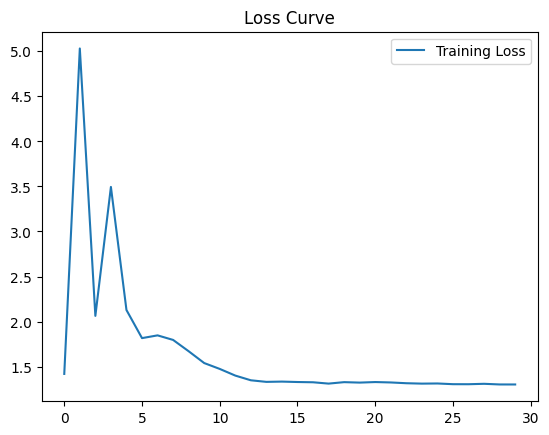

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses, label="Training Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

#### Confusion Matrix

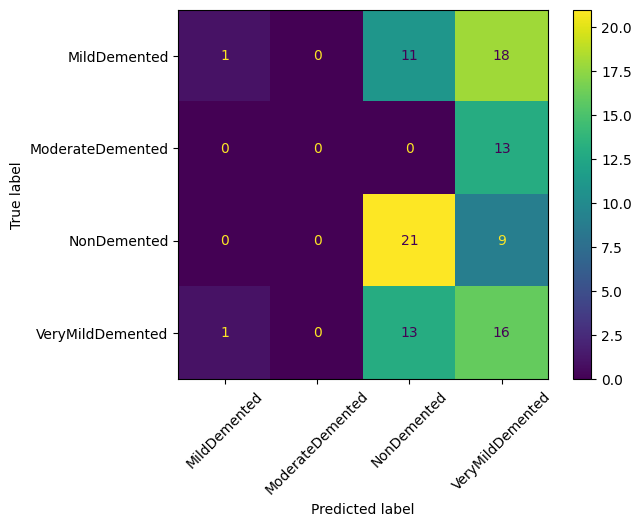

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
preds = model(data)[test_mask].argmax(dim=1).cpu().numpy()
true = data.y[test_mask].cpu().numpy()

cm = confusion_matrix(true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.values())
disp.plot(xticks_rotation=45)
plt.show()

#### ROC Curve

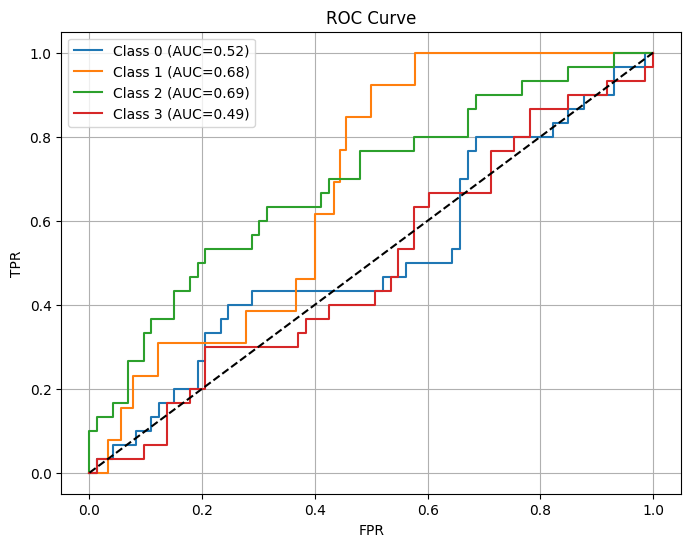

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

model.eval()
y_score = model(data)[test_mask].detach().numpy()
y_test_bin = label_binarize(true, classes=[0,1,2,3])

fpr = {}
tpr = {}
roc_auc = {}

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC={roc_auc[i]:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import os
from collections import Counter

dataset_path = '/content/Alzheimer_MRI_4_classes_dataset'

# Count the number of images in each class
class_counts = {}

for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        num_images = len([f for f in os.listdir(class_dir) if f.endswith('.jpg')])
        class_counts[class_name] = num_images

# Display results
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")


VeryMildDemented: 2240 images
NonDemented: 3200 images
MildDemented: 896 images
ModerateDemented: 64 images


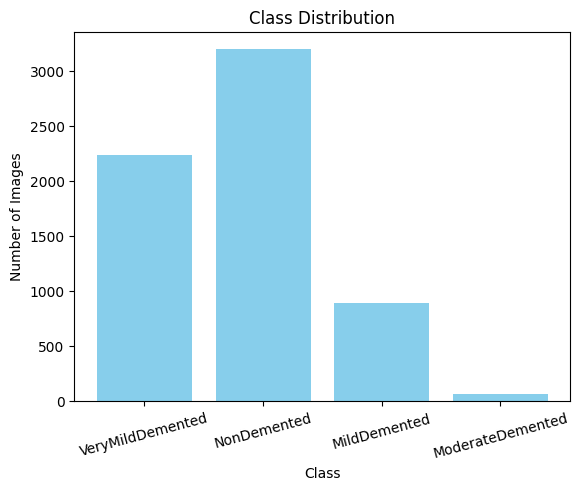

In [ ]:
import matplotlib.pyplot as plt

plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=15)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import models

### Define Data Preprocessing and DataLoader

we define the necessary transformations for the images i.e resize and normalize, and create a DataLoader to iterate over the dataset

In [ ]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model input size
    transforms.ToTensor(),          # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

# Load dataset using ImageFolder
train_dataset = datasets.ImageFolder('/content/Alzheimer_MRI_4_classes_dataset', transform=transform)

# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


### Define Model (ResNet18)

In [ ]:
# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Change the final fully connected layer to match the number of classes (4 classes)
model.fc = nn.Linear(model.fc.in_features, 4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Compute Class Weights

In [ ]:
import torch

class_sample_counts = [3200, 2240, 896, 64]

# Compute weights (1 / frequency of class)
weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)

# Normalize weights so they sum to 1
weights = weights / weights.sum()

# Convert weights to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = weights.to(device)

print(f"Class weights: {weights}")


Class weights: tensor([0.0179, 0.0255, 0.0638, 0.8929])


### Define Loss Function and Optimizer

In [ ]:
# Define the loss function (with class weights)
loss_fn = nn.CrossEntropyLoss(weight=weights)

# Define the optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training Loop

create a training loop where we calculate the loss, perform backpropagation, and update the model's parameters

In [ ]:
# Set the model to the chosen device (GPU or CPU)
model.to(device)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_preds / total_preds
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_accuracy:.4f}")

Epoch 1/10 | Loss: 0.3297 | Accuracy: 0.4575
Epoch 2/10 | Loss: 0.2746 | Accuracy: 0.5123
Epoch 3/10 | Loss: 0.2023 | Accuracy: 0.6323
Epoch 4/10 | Loss: 0.1448 | Accuracy: 0.7267
Epoch 5/10 | Loss: 0.1020 | Accuracy: 0.7875
Epoch 6/10 | Loss: 0.0798 | Accuracy: 0.8172
Epoch 7/10 | Loss: 0.0627 | Accuracy: 0.8380
Epoch 8/10 | Loss: 0.0417 | Accuracy: 0.8738
Epoch 9/10 | Loss: 0.0807 | Accuracy: 0.8414
Epoch 10/10 | Loss: 0.0449 | Accuracy: 0.8852


### Prepare the Test Dataset & Dataloader

In [ ]:
from sklearn.model_selection import train_test_split
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset

# Get all indices and split them
all_indices = list(range(len(train_dataset)))
train_idx, test_idx = train_test_split(all_indices, test_size=0.2, stratify=train_dataset.targets, random_state=42)

train_data = Subset(train_dataset, train_idx)
test_data = Subset(train_dataset, test_idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


### Evaluation

In [ ]:
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize


#### Evaluation on the Test Set

In [ ]:
model.eval()
y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())

#### Class names handling

In [ ]:
class_names = train_dataset.dataset.classes if hasattr(train_dataset, 'dataset') else train_dataset.classes

#### Accuracy and classification report

In [ ]:
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Test Accuracy: {acc:.4f}\n")
print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))



✅ Test Accuracy: 0.8578

📋 Classification Report:

                  precision    recall  f1-score   support

    MildDemented       0.98      0.22      0.36       179
ModerateDemented       1.00      0.15      0.27        13
     NonDemented       0.80      1.00      0.89       640
VeryMildDemented       0.95      0.93      0.94       448

        accuracy                           0.86      1280
       macro avg       0.93      0.58      0.61      1280
    weighted avg       0.88      0.86      0.83      1280



#### Confusion Matrix

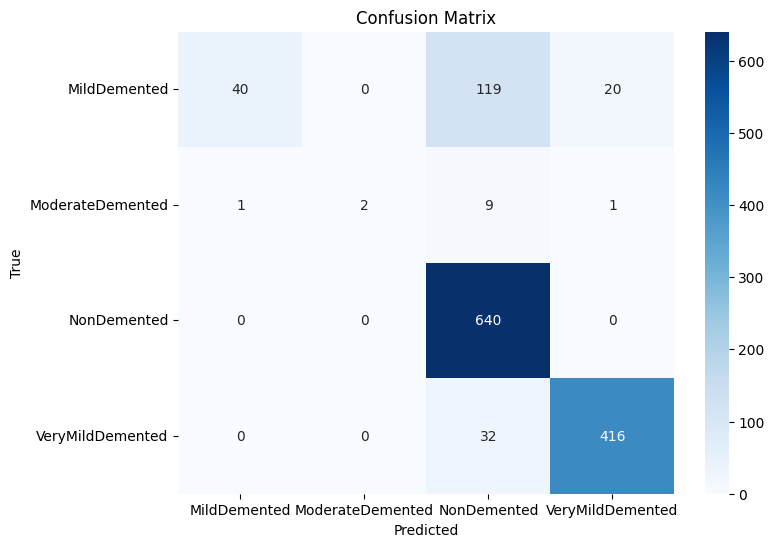

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### ROC Curve

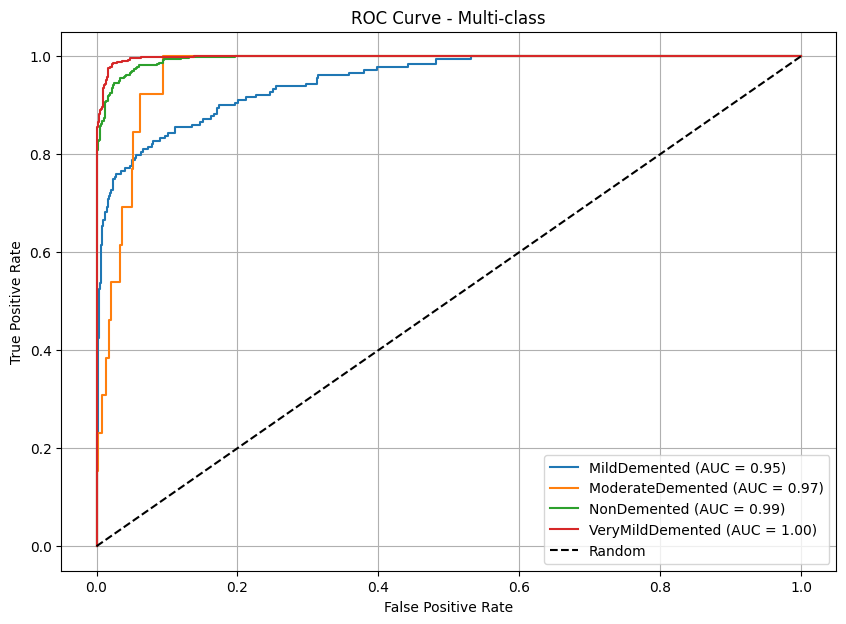

In [ ]:
# One-hot encode the true labels
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
y_scores = np.array(y_scores)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 7))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### Loss curve

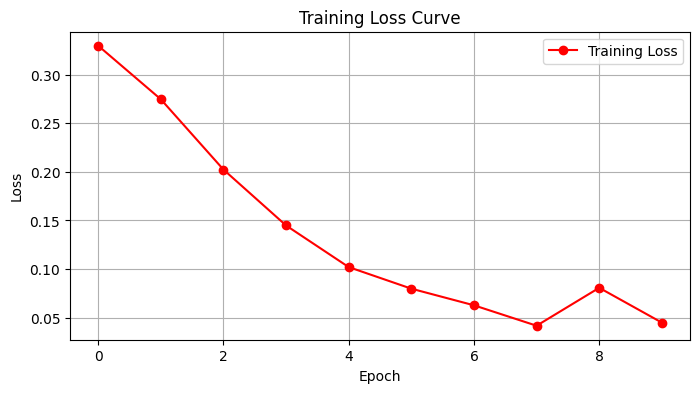

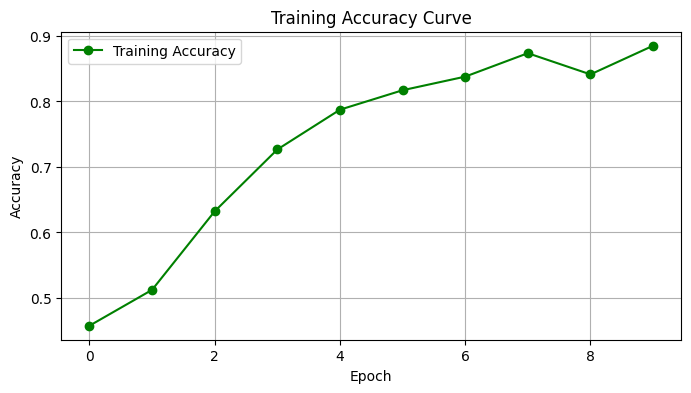

In [ ]:
import matplotlib.pyplot as plt

train_losses = [0.3297, 0.2746, 0.2023, 0.1448, 0.1020, 0.0798, 0.0627, 0.0417, 0.0807, 0.0449]
train_accuracies = [0.4575, 0.5123, 0.6323, 0.7267, 0.7875, 0.8172, 0.8380, 0.8738, 0.8414, 0.8852]

# Plot Loss Curve
plt.figure(figsize=(8, 4))
plt.plot(train_losses, marker='o', color='red', label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(8, 4))
plt.plot(train_accuracies, marker='o', color='green', label='Training Accuracy')
plt.title('Training Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import torch

# Model weights (state_dict)
torch.save(model.state_dict(), 'alzheimer_cnn_model_weights.pth')
print("Model weights saved!")

# Full model (with architecture and weights)
torch.save(model, 'alzheimer_cnn_model_full.pth')
print("Full model saved!")

Model weights saved!
Full model saved!




# Apply GNN with the Cora Dataset. Show Accuracy, confusion matrix, Roc,and loss curve.

In [ ]:
pip install torch torchvision torchaudio torch-geometric scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


## Load the Cora Dataset

The Cora dataset is used. It consists of 2708 scientific publications representaed as nodes with 5429 citation links forming edges between them. each node is described by a 1433-dimensional binary feature vector that captures the presence of specific words in the corresponding paper. The publications are classified into seven distinct machine learning topics.

In [ ]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load dataset
dataset = Planetoid(root='data/Cora', name='Cora')
data = dataset[0]

Processing...
Done!


In [ ]:
print(dataset)           # Overview of the dataset
print(data)              # Overview of the graph data object
print(data.x.shape)      # Feature matrix shape (nodes × features)
print(data.y.shape)      # Labels
print(data.edge_index)   # Edge connections (citation graph)
print(data.train_mask)   # Boolean mask for training nodes

Cora()
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
torch.Size([2708, 1433])
torch.Size([2708])
tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])
tensor([ True,  True,  True,  ..., False, False, False])


In [ ]:
print("First 5 feature vectors:")
print(data.x[:5])

print("First 5 labels:")
print(data.y[:5])

First 5 feature vectors:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
First 5 labels:
tensor([3, 4, 4, 0, 3])


In [ ]:
label_names = [
    "Case_Based",
    "Genetic_Algorithms",
    "Neural_Networks",
    "Probabilistic_Methods",
    "Reinforcement_Learning",
    "Rule_Learning",
    "Theory"
]

for i in range(7):
    label_index = data.y[i].item()
    print(f"Node {i} → Label: {label_index} → Class: {label_names[label_index]}")

Node 0 → Label: 3 → Class: Probabilistic_Methods
Node 1 → Label: 4 → Class: Reinforcement_Learning
Node 2 → Label: 4 → Class: Reinforcement_Learning
Node 3 → Label: 0 → Class: Case_Based
Node 4 → Label: 3 → Class: Probabilistic_Methods
Node 5 → Label: 2 → Class: Neural_Networks
Node 6 → Label: 0 → Class: Case_Based


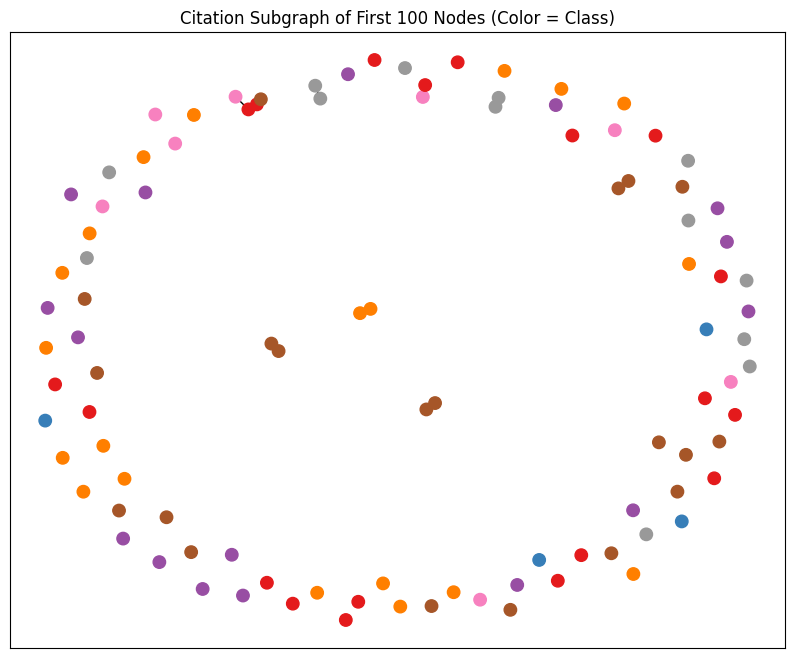

In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

# Convert to NetworkX for easy visualization
G = to_networkx(data, to_undirected=True)

# Draw a subgraph of the first 100 nodes
plt.figure(figsize=(10, 8))
sub_nodes = list(range(100))
subgraph = G.subgraph(sub_nodes)

# Get labels for color coding
colors = [data.y[n].item() for n in subgraph.nodes]

nx.draw_networkx(
    subgraph,
    node_color=colors,
    with_labels=False,
    node_size=80,
    cmap=plt.cm.Set1
)
plt.title("Citation Subgraph of First 100 Nodes (Color = Class)")
plt.show()

## Define a GNN Model

Define the clss GCN which defines a 2-layer Graph Convolutional Network (GCN) used for node classification tasks in graph-structure data.

- **self.conv1**: First GCN layer that tranforms input node features to 16 hidden dimensions.

- **self.conv2**: second layer that maps from the hidden layes to the number of output classes.


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index   # Retrieves node features and graph connectivity
        x = F.relu(self.conv1(x, edge_index))     # Applies the first graph convolution and F.relu adds non-linearity via ReLU activation
        x = F.dropout(x, training=self.training)  # Applies dropout regularization during training
        x = self.conv2(x, edge_index)             # Final GCN layes outputs class logits for each node
        return x

- The GCN layers aggregate feature information from each node's neighbors.

- Dropout helps prevent overfitting by randomly dropping features during training.

- The final output is a raw class score (logits) for each node.




## Train the model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

losses = []
accuracies = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    accuracies.append(acc)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

Epoch 0, Loss: 1.9391, Accuracy: 0.1840
Epoch 20, Loss: 0.2137, Accuracy: 0.7260
Epoch 40, Loss: 0.0576, Accuracy: 0.7430
Epoch 60, Loss: 0.0424, Accuracy: 0.7430
Epoch 80, Loss: 0.0316, Accuracy: 0.7410
Epoch 100, Loss: 0.0393, Accuracy: 0.7280
Epoch 120, Loss: 0.0324, Accuracy: 0.7620
Epoch 140, Loss: 0.0331, Accuracy: 0.7510
Epoch 160, Loss: 0.0273, Accuracy: 0.7640
Epoch 180, Loss: 0.0284, Accuracy: 0.7480


## Evaluation

### Loss curve

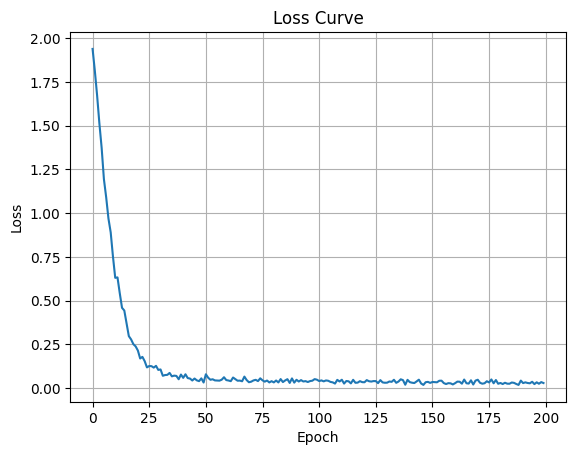

In [ ]:
plt.plot(losses)
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

### Confusion Matrix

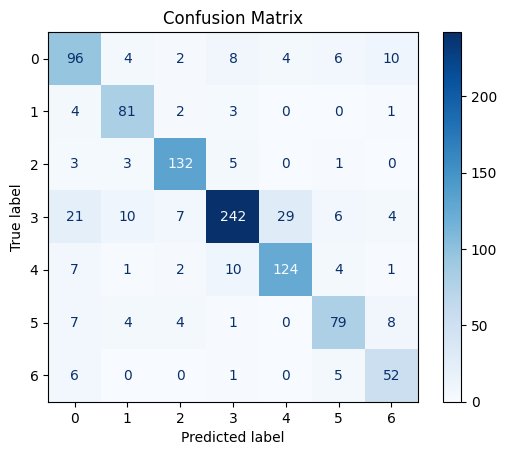

Test Accuracy: 0.8060


In [ ]:
model.eval()
out = model(data)
pred = out.argmax(dim=1)

y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Accuracy
accuracy = (y_pred == y_true).sum() / len(y_true)
print(f"Test Accuracy: {accuracy:.4f}")

### ROC Curve (One-vs-Rest)

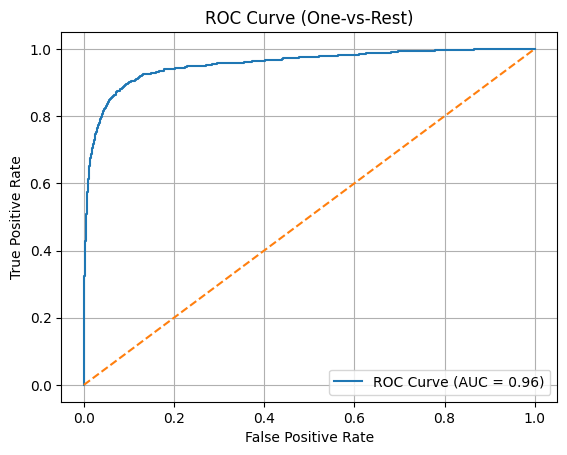

In [ ]:
from sklearn.preprocessing import label_binarize

# Binarize for ROC
y_test_bin = label_binarize(y_true, classes=list(range(dataset.num_classes)))
y_score = out[data.test_mask].detach().cpu().numpy()

fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


#

# Apply GNN with Pyspark with the Cora Dataset. Show Accuracy, confusion matrix, Roc,and loss curve.

## PySpark Setup & Load Data

In [2]:
from pyspark.sql import SparkSession
import pandas as pd

# Initialize PySpark
spark = SparkSession.builder \
    .appName("Cora GNN Preprocessing") \
    .getOrCreate()

# Load data from torch_geometric into pandas first
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='data/Cora', name='Cora')
data = dataset[0]

# Convert feature matrix and labels to DataFrame
df_features = pd.DataFrame(data.x.numpy())
df_features['label'] = data.y.numpy()

# Send to PySpark
spark_df = spark.createDataFrame(df_features)
# spark_df.printSchema()
spark_df.show(5)


+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---

## Preprocess

In [18]:
pip install numpy==1.24.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 46.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is 

In [4]:
feature_cols = [str(c) for c in df_features.columns[:-1]]  # Convert all to string column names

# When converting to Spark DataFrame
df_features.columns = feature_cols + ['label']  # Ensure the last column is called 'label'

# Create Spark DataFrame
spark_df = spark.createDataFrame(df_features)

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vec")
assembled = assembler.transform(spark_df)
assembled.show(5)


+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---

In [5]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features_vec", outputCol="scaled_features", withStd=True, withMean=False)
scaler_model = scaler.fit(assembled)
scaled_data = scaler_model.transform(assembled)
scaled_data.select("scaled_features", "label").show(5, truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|scaled_features                                                                                                                                                                                                                                                                                                                                                                                                                                                             

## Export from Spark to PyTorch

In [6]:
import numpy as np
import torch

# Step 1: Collect scaled features and labels from Spark
scaled_features = scaled_data.select("scaled_features").rdd \
    .map(lambda row: row["scaled_features"].toArray()) \
    .collect()

labels = scaled_data.select("label").rdd \
    .map(lambda row: int(row["label"])) \
    .collect()

# Step 2: Convert to PyTorch tensors
x_tensor = torch.tensor(np.array(scaled_features), dtype=torch.float)
y_tensor = torch.tensor(labels, dtype=torch.long)

# Step 3: Inject into the PyG data object
from torch_geometric.datasets import Planetoid

# Load data structure again (or reuse your previous `data`)
dataset = Planetoid(root='data/Cora', name='Cora')
data = dataset[0]

# Replace the default features and labels with the Spark-scaled ones
data.x = x_tensor
data.y = y_tensor

print(f"Updated feature matrix: {data.x.shape}")
print(f"Updated labels shape: {data.y.shape}")


Updated feature matrix: torch.Size([2708, 1433])
Updated labels shape: torch.Size([2708])


## Define GCN Model

In [7]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x


## Train the Model


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

losses = []
accuracies = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()
    acc = correct / int(data.test_mask.sum())
    accuracies.append(acc)

    if epoch % 20 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Accuracy: {acc:.4f}")


Epoch 0 | Loss: 2.2106 | Accuracy: 0.1630
Epoch 20 | Loss: 0.0125 | Accuracy: 0.7190
Epoch 40 | Loss: 0.0100 | Accuracy: 0.6930
Epoch 60 | Loss: 0.0075 | Accuracy: 0.6970
Epoch 80 | Loss: 0.0032 | Accuracy: 0.7110
Epoch 100 | Loss: 0.0067 | Accuracy: 0.6860
Epoch 120 | Loss: 0.0336 | Accuracy: 0.7240
Epoch 140 | Loss: 0.0237 | Accuracy: 0.7230
Epoch 160 | Loss: 0.0026 | Accuracy: 0.7220
Epoch 180 | Loss: 0.0057 | Accuracy: 0.7140


## Evaluation

### Plot Loss Curve

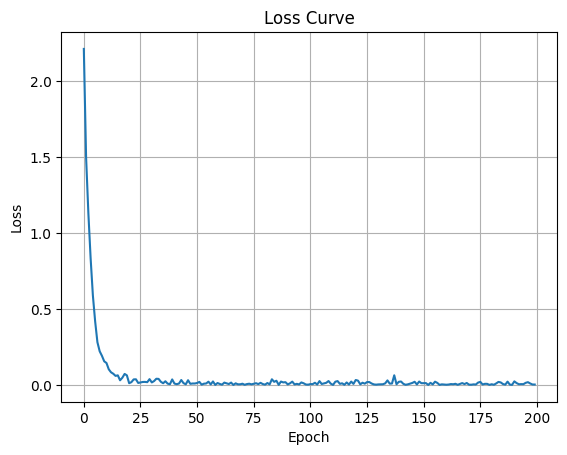

In [9]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


### Confusion Matrix

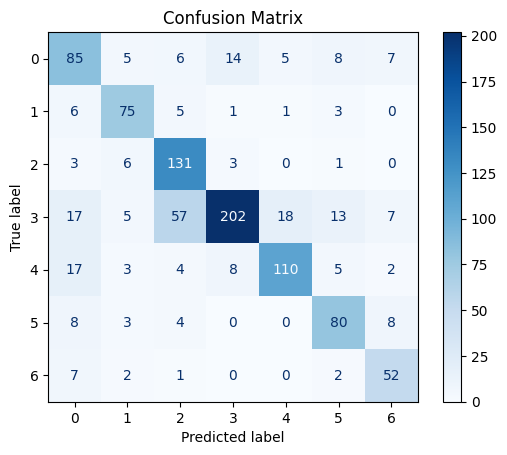

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predictions
model.eval()
out = model(data)
pred = out.argmax(dim=1)

# Extract true/pred labels from test set
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


### Accuracy

In [11]:
accuracy = (y_pred == y_true).sum() / len(y_true)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7350


### ROC Curve & AUC


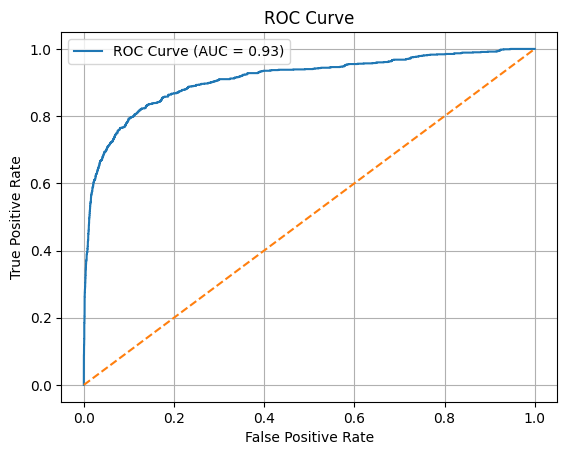

In [12]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score

# Binarize classes for ROC (One-vs-Rest)
y_test_bin = label_binarize(y_true, classes=list(range(dataset.num_classes)))
y_score = out[data.test_mask].detach().cpu().numpy()

# Compute ROC and AUC
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")

# Plot ROC Curve
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()
